In [1]:
'''
Tom Egg
October 2, 2023
File to attempt analysis of tripeptoid enhanced sampling
'''

'\nTom Egg\nOctober 2, 2023\nFile to attempt analysis of tripeptoid enhanced sampling\n'

In [1]:
# Import libraries
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import csv

# Collective Variables and Free Energy Surface

To plot the free energy surface of the Sarcosine Tripeptoid projected onto several collective variables, I first run a TAMD simulation for 100 ns. After this, I
histogram the extended variables and transform them to free energy values by the equation:
$$
    F(s_1, ..., s_n) = - \frac{1}{\tilde{\beta}} \ln{\tilde{P}(s_1, ..., s_n)}
$$
Where $\tilde{\beta}$ is the inverse of elevated temperature.

In [2]:
# COLVAR
file_path = '/scratch/tje3676/openmm-test/tri_output.csv'

# Attempt to load
df = pd.read_csv(file_path)

In [3]:
df.head()

,"#""Step""",s_phi,phi,s_psi,psi,Speed (ns/day)
0,10,-1.657290,-1.654603,3.121225,3.116265,0
1,20,-1.673392,-1.673385,3.134366,3.132362,121
2,30,-1.690975,-1.690452,-3.134282,-3.137795,122
3,40,-1.710936,-1.713041,-3.117337,-3.126837,123
4,50,-1.733894,-1.743573,-3.096902,-3.094630,123


## $\psi_1$ vs $\phi_1$

In [4]:
# Histogram variables
hist = np.zeros((20, 20))
x_edge = None
y_edge = None

# Histogram
hist, x_edges, y_edges = np.histogram2d(df['s_phi'], df['s_psi'], bins=[20, 20])
hist[hist == 0] = 1

In [5]:
# Transform to free energy:
def distribution_to_FE(hist):

    # Apply transformation
    hist = - (3000 * (8.314472 ** -3)) * np.log(hist)
    return hist / 4.214

# Convert histogram to FE histogram
hist = distribution_to_FE(hist)

# Shift histogram
min_value = np.min(hist)
hist = hist - min_value

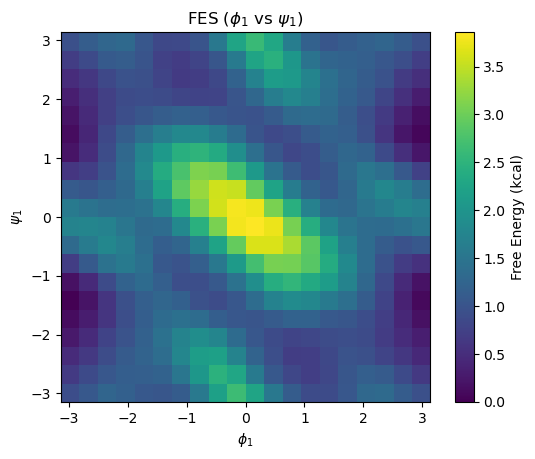

In [7]:
# Create a heatmap or 2D histogram plot
plt.imshow(hist, extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]], origin='lower', cmap='viridis')
plt.colorbar(label='Free Energy (kcal)')
plt.xlabel('$\phi_1$')
plt.ylabel('$\psi_1$')
plt.title('FES ($\phi_1$ vs $\psi_1$)')
plt.show()

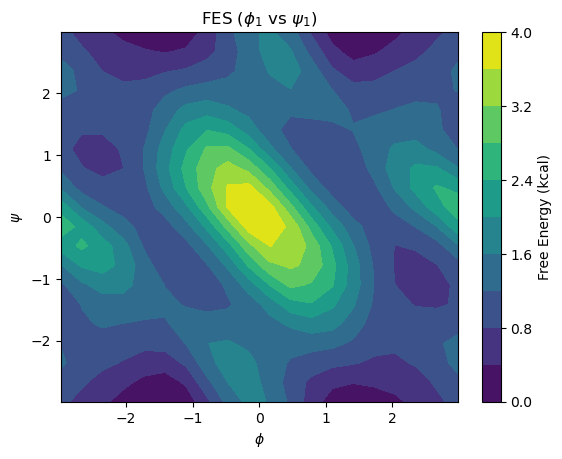

In [8]:
# Work with centers
x_centers = (x_edges[1:] + x_edges[:-1]) / 2
y_centers = (y_edges[1:] + y_edges[:-1]) / 2

# Create a heatmap or 2D histogram plot
plt.contourf(x_centers, y_centers, hist.T, levels=9, cmap='viridis')
plt.colorbar(label='Free Energy (kcal)')
plt.xlabel('$\phi$')
plt.ylabel('$\psi$')
plt.title('FES ($\phi_1$ vs $\psi_1$)')
plt.show()

## $L^2$ Error

After plotting the FES for the Tripeptoid system, I will plot the $L^2$ Error to quantify how the TAMD simulation converges to zero error. I take 
histograms at regular intervals, calculate the free energy norm, and plot the resulting curve to get an idea of how the FES converges as my simulation
is carried out.

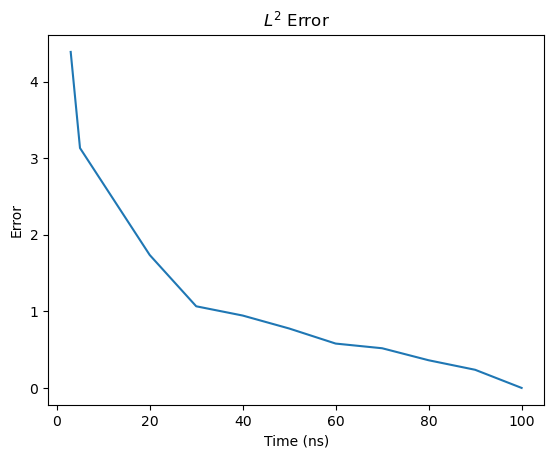

In [22]:
# Set reference histogram
ref_hist = hist

# List of values to sample energy at
vals = [3, 5] + [x*10 for x in range(2, 11)]
L2 = []

# Iterate over values 
for val in vals:

    # Get histogram of values
    t_hist, x_edges, y_edges = np.histogram2d(df['s_phi'][:val * 100000], df['s_psi'][:val * 100000], bins=[20, 20])
    t_hist[t_hist == 0] = 1

    # Transform values to FES
    t_hist = distribution_to_FE(t_hist)

    # Shift histogram
    min_value = np.min(t_hist)
    t_hist = t_hist - min_value

    # Calculate norm and append to histogram    
    norm = np.linalg.norm(t_hist - ref_hist)
    L2.append(norm)

# Plot error
plt.title('$L^2$ Error')
plt.xlabel('Time (ns)')
plt.ylabel('Error')
plt.plot(vals, L2)
plt.show()

# Transition Path Sampling